## Compute Laplacian

In [1]:
## IMPORT LIBRARIES 
import os
import sys
import igl
import time
import torch
import numpy as np
import meshplot as mp
from typing import Tuple
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## IMPORT SOURCE
from smpl_torch_batch import SMPLModel

In [2]:
## LOAD ANIMATION DATA (ORIGINAL SCANS OF SINGLE INSTANCE)

training_data = torch.load('../data/50004_dataset.pt')
data_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=False)

device = "cpu"
smpl_model = SMPLModel(device=device, model_path='../body_models/smpl/female/model.pkl')

for data in data_loader:
    target_verts = data[1].squeeze()
    V = np.array(target_verts, dtype=float)
    F = np.array(smpl_model.faces, dtype=int)
    break

frames = 20
with np.load(f"../results/eigdecomp_batch_{frames}_frames.npz") as file:
    V_selected = file['arr_0']
    eigvals = file['arr_3']
    eigvecs = file['arr_4']
    

## Experiments

In [3]:
def generate_sine_wave(
    amplitude: float,
    frequency: float,
    phase: float,
    sampling_rate: int,
    duration: float) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """Generates a sine wave

    Args:
        amplitude (float): Amplitude
        frequency (float): Frequnecy [Hz]
        phase (float): Phase [rad]
        sampling_rate (int): Sampling rate[Hz]
        duration (float): Duration [s]

    Returns:
        Tuple[torch.FloatTensor, torch.FloatTensor]: t, y(t)
    """
    total_steps = int(sampling_rate * duration)
    t = torch.linspace(0, duration, total_steps)
    y = amplitude * torch.sin(2 * np.pi * frequency * t + phase)

    return t, y

In [4]:
def get_fft_components(signal, fourier, sampling_rate = 1_000, plot=True):
    absolutes = fourier.abs()
    freq = torch.fft.rfftfreq(len(signal), 1/sampling_rate)
    
    if plot:
        fig, ax = plt.subplots()
        ax.set_xlabel('Frequencies')
        ax.set_ylabel('$|F(s)|$')
        ax.grid()
        ax.scatter(x=freq, y=absolutes, s=8)
        plt.savefig('./plots/fourier_transform_sampling_{}_{}.png'.format(sampling_rate, time.time()))
    
    return absolutes, freq

In [5]:
V_tensor = torch.from_numpy(V_selected)
eigvals_tensor = torch.from_numpy(eigvals.real)
eigvecs_tensor = torch.from_numpy(eigvecs.real)

print(V_tensor.shape, eigvals_tensor.shape, eigvecs_tensor.shape)

torch.Size([20, 6890, 3]) torch.Size([20, 10]) torch.Size([20, 6890, 10])


In [7]:
###### FFT Computation (Naive)

duration = period = V_tensor.shape[0]
num_verts = V_tensor.shape[1]
dims = V_tensor.shape[2]
num_eigvals = eigvals.shape[1]

eigdecomp_anim = []
for vertex in range(num_verts):
    eigvecs_abs = []
    eigvecs_freqs = []
    for eigval_idx in range(num_eigvals):
       
        signal = eigvecs_tensor[:, vertex, eigval_idx]
        
        signal_fourier = torch.fft.rfft(signal, norm='forward') 
        absolutes, freqs = get_fft_components(signal, signal_fourier, plot=False)

        eigvecs_freqs.append(freqs)
        eigvecs_abs.append(absolutes)
    
    if (vertex+1) % 500 == 0:
        print(">> Step ", vertex+1 , "/", num_verts)
    eigdecomp_anim.append((eigvecs_freqs, eigvecs_abs))

>> Step  500 / 6890
>> Step  1000 / 6890
>> Step  1500 / 6890
>> Step  2000 / 6890
>> Step  2500 / 6890
>> Step  3000 / 6890
>> Step  3500 / 6890
>> Step  4000 / 6890
>> Step  4500 / 6890
>> Step  5000 / 6890
>> Step  5500 / 6890
>> Step  6000 / 6890
>> Step  6500 / 6890


In [8]:
#for i in range(period):
#    plt.plot(eigvals.real[i])

In [9]:
print(eigvecs_abs[0].shape, eigvecs_freqs[0].shape)
print(len(eigvecs_abs), len(eigvecs_freqs))
print(len(eigdecomp_anim))

torch.Size([11]) torch.Size([11])
10 10
6890


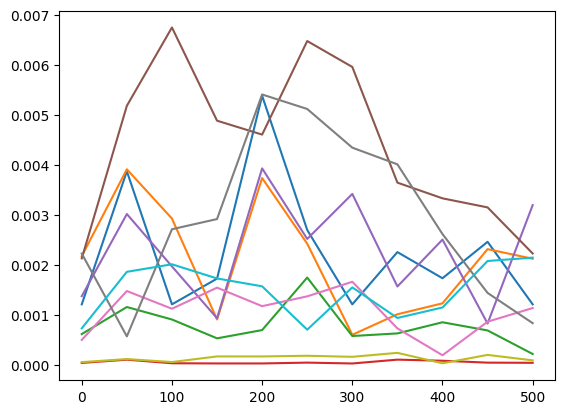

In [10]:
max_eig_components = 100

for i in range(num_eigvals):
    freqs = eigvecs_freqs[i][0:max_eig_components]
    absolutes = eigvecs_abs[i][0:max_eig_components]
    plt.plot(freqs, absolutes)

In [ ]:
# PLOT THE ADDED JIGGLING ANIMATION

v_start = V_selected[0]
p = mp.plot(v_start, F)
anim_length = V_selected.shape[0]

for k in range(10):
    for i in range(anim_length):
        
        v_new = V_selected[i]
        p.update_object(vertices=v_new)
        v = v_new
        time.sleep(0.1)